# Script to produce Figure 1 in the paper

### This is a plot of VIIRS-I05 BT data for the super cold BT event.

It uses NASA's VIIRS data, which contains radiances rather than the BTs in NOAA's CLASS archive.
You can download this data from NASA's Earthdata search: https://search.earthdata.nasa.gov/search

In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d
from IPython.display import display
from pydecorate import DecoratorAGG
from trollimage.image import Image
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import trollimage.colormap
from matplotlib import cm
from satpy import Scene
from glob import glob
import numpy as np
import importlib
import netCDF4
import aggdraw

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Set up a font, I have to specify a full path so you may need to change this on your system
font = aggdraw.Font('black',
                    "/usr/share/fonts/truetype/ttf-dejavu/DejaVuSerif.ttf",
                    size=36)

In [3]:
# Set this to wherever you have VJ02 and VJ03 data
viirs_dir = '/gf2/eodg/SRP001_PROUD_TURBREP/Supercold/VIIRS_J/'

# Search for files, specify part of timestamp to only get those associated with Kammuri
files = glob(viirs_dir + '*1336*.nc')

# Initialise scene and load data
scn_vi = Scene(files, reader='viirs_l1b')
scn_vi.load(['I05'], calibration='brightness_temperature')

# Get the scene start time as a string
start_dtstr = scn_vi.attrs['start_time'].strftime("%Y-%m-%d %H:%M:%S")

In [4]:
# Resample data onto fixed grid
my_area = scn_vi['I05'].attrs['area'].compute_optimal_bb_area({'proj': 'lcc', 'lon_0': -95., 'lat_0': 25., 'lat_1': 25., 'lat_2': 25.})
new_scn = scn_vi.resample(my_area)

In [8]:
new_scn.save_dataset('I05',
                            dtype=np.float32,
                            enhance=False,
                            fill_value=0,
                            filename='/home/proud/Desktop/tmp.tiff')

In [9]:

# Now subset, as working with the whole scene is unweidly
# Crop region is manually defined by looking at output image
new_bnd = (-11492394, 541995, -10776088, 1193409)
new_scn2 = new_scn.crop(xy_bbox = new_bnd)

# Get the CRS to use later in plotting
crs = new_scn2['I05'].attrs['area'].to_cartopy_crs()

# Extract the Brightness Temperatures, useful for quick plots
bt_vals = np.array(new_scn2['I05'])

In [19]:
# This section creates the matplotlib colourmap based on three trollimage colormaps.
# There may be a simpler way to do this, but the code here works.

# We reload the colormaps, otherwise it can get confusing if we adjust settings multiple times
importlib.reload(trollimage.colormap)
greys = trollimage.colormap.greys
ylorrd = trollimage.colormap.ylorrd
rdbu = trollimage.colormap.rdbu

# Set colormap limits (in K)
grey_max = 273.
grey_min = 200.
yor_max = grey_min - 0.5
yor_min = 180.
rdb_max = 177
rdb_min = 161.

# Create the initial color maps
greys.set_range(grey_min, grey_max)
ylorrd.set_range(yor_min, yor_max)
rdbu.set_range(rdb_min, rdb_max)
ylorrd.reverse()
rdbu.reverse()

# Create a combined cmap
my_cm = rdbu + ylorrd + greys

# Slightly adjust two RGB components for a better plot
my_cm.colors[10,:] = my_cm.colors[10,:] * 1.2
my_cm.colors[11,:] = my_cm.colors[10,:] * 1.2

# Interpolate this colourmap for scaling into matplotlib
fr = interp1d(my_cm.values, my_cm.colors[:,0])
fg = interp1d(my_cm.values, my_cm.colors[:,1])
fb = interp1d(my_cm.values, my_cm.colors[:,2])

# Create new x-axis with 256 points
xnew = np.linspace(np.nanmin(my_cm.values), np.nanmax(my_cm.values), num=256, endpoint=True)

# Load matplotlib colourmap
cmap = cm.get_cmap('Oranges', 256)
newcmp = ListedColormap(cmap(np.linspace(0, 1, 256)), name='VIIRS_BT')

# Replace the values in this colourmap with ones from our custom scale.
newcmp.colors[:,0] = fr(xnew)
newcmp.colors[:,1] = fg(xnew)
newcmp.colors[:,2] = fb(xnew)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


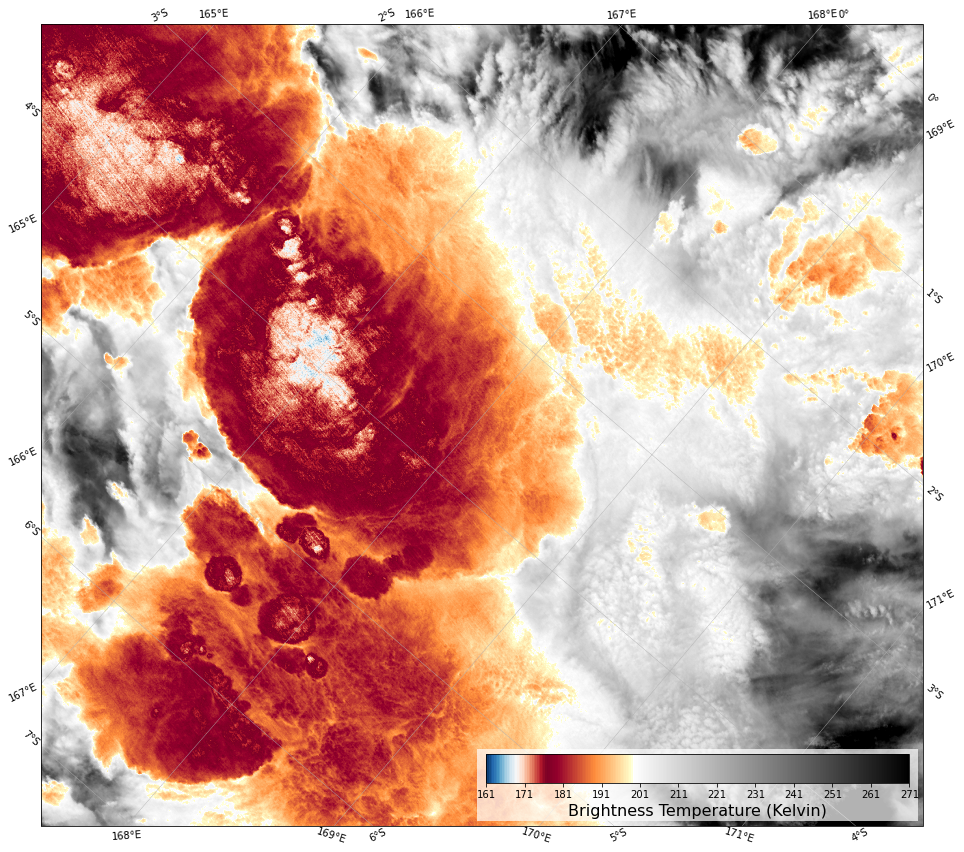

In [22]:
# Set min and max BT for the image
min_bt = 161
max_bt = 271

# Create figure using custom projection defined by satpy
fig = plt.figure(figsize=(13.84*1.5, 7.96*1.5))
ax = fig.add_subplot(1, 1, 1, projection=crs)
# Add some gridlines for easier orientation
ax.gridlines(draw_labels=True,
             dms=True,
             x_inline=False,
             y_inline=False,
             linewidth=0.4)

# Add the VIIRS data to the plot, can be slow
plt.imshow(new_scn2['I05'],# Add this to make quicker, subsampled, plot: [::10, ::10],
           transform=crs,
           extent=crs.bounds,
           origin='upper',
           cmap=newcmp,
           vmin=min_bt,
           vmax=max_bt)

# Define colourbar ticks
ticks = np.linspace(min_bt, max_bt, 12)

# Create the colour bar. This is a faff as matplotlib is not good at this
# First we create an inset axis, then another within that
# The outer axis enables a background colour to be used, which helps readability
cbbox = inset_axes(ax, width="50%", height="9%", loc=4)
cbbox.set_xticks([])
cbbox.set_yticks([])
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
# Make background white, but slightly transparent
cbbox.set_facecolor([1,1,1,0.7])

# Create the real colorbar axis within the above
cbaxes = inset_axes(cbbox, '96%', '40%', loc = 9)

# Add the actual colourbar now
cbar = plt.colorbar(cax=cbaxes, ticks=ticks, orientation='horizontal')
cbar.set_label("Brightness Temperature (Kelvin)", fontsize=16)

# Save the output
plt.savefig('../Figures/Figure_1.eps', format='eps', facecolor='white', bbox_inches='tight')
plt.savefig('../Figures/Figure_1.png', facecolor='white', bbox_inches='tight')